The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0
!pip install -U mxnet-cu101==1.7.0


# Gradient Descent
:label:`sec_gd`

In this section we are going to introduce the basic concepts underlying *gradient descent*.
Although it is rarely used directly in deep learning, an understanding of gradient descent is key to understanding stochastic gradient descent algorithms.
For instance, the optimization problem might diverge due to an overly large learning rate. This phenomenon can already be seen in gradient descent. Likewise, preconditioning is a common technique in gradient descent and carries over to more advanced algorithms.
Let's start with a simple special case.


## One-Dimensional Gradient Descent

Gradient descent in one dimension is an excellent example to explain why the gradient descent algorithm may reduce the value of the objective function. Consider some continuously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion we obtain

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$
:eqlabel:`gd-taylor`

That is, in first-order approximation $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. It is not unreasonable to assume that for small $\epsilon$ moving in the direction of the negative gradient will decrease $f$. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$
:eqlabel:`gd-taylor-2`

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher-order terms to become irrelevant. Hence we arrive at

$$f(x - \eta f'(x)) \lessapprox f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes.


In [1]:
%matplotlib inline
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

In [2]:
def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ for 10 times we can see that, eventually, the value of $x$ approaches the optimal solution.


In [3]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


The progress of optimizing over $x$ can be plotted as follows.


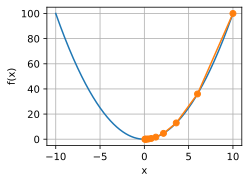

In [4]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = np.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### Learning Rate
:label:`subsec_gd-learningrate`

The learning rate $\eta$ can be set by the algorithm designer. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.


epoch 10, x: 3.486784


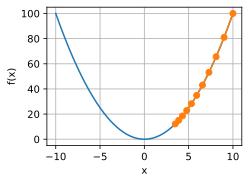

In [5]:
show_trace(gd(0.05, f_grad), f)

Conversely, if we use an excessively high learning rate, $\left|\eta f'(x)\right|$ might be too large for the first-order Taylor expansion formula. That is, the term $\mathcal{O}(\eta^2 f'^2(x))$ in :eqref:`gd-taylor-2` might become significant. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$. For example, when we set the learning rate to $\eta=1.1$, $x$ overshoots the optimal solution $x=0$ and gradually diverges.


epoch 10, x: 61.917364


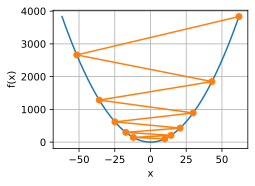

In [6]:
show_trace(gd(1.1, f_grad), f)

### Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


epoch 10, x: -1.528165


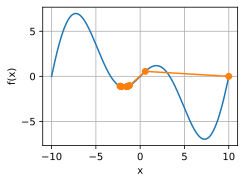

In [7]:
c = np.array(0.15 * np.pi)

def f(x):  # Objective function
    return x * np.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2, f_grad), f)

## Multivariate Gradient Descent

Now that we have a better intuition of the univariate case, let's consider the situation where $\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$. That is, the objective function $f: \mathbb{R}^d \to \mathbb{R}$ maps vectors into scalars. Correspondingly its gradient is multivariate, too. It is a vector consisting of $d$ partial derivatives:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

Each partial derivative element $\partial f(\mathbf{x})/\partial x_i$ in the gradient indicates the rate of change of $f$ at $\mathbf{x}$ with respect to the input $x_i$. As before in the univariate case we can use the corresponding Taylor approximation for multivariate functions to get some idea of what we should do. In particular, we have that

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$
:eqlabel:`gd-multi-taylor`

In other words, up to second-order terms in $\boldsymbol{\epsilon}$ the direction of steepest descent is given by the negative gradient $-\nabla f(\mathbf{x})$. Choosing a suitable learning rate $\eta > 0$ yields the prototypical gradient descent algorithm:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

To see how the algorithm behaves in practice let's construct an objective function $f(\mathbf{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input and a scalar as output. The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5, -2]$.

To begin with, we need two more helper functions. The first uses an update function and applies it 20 times to the initial value. The second helper visualizes the trajectory of $\mathbf{x}$.


In [8]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1),
                          np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

Next, we observe the trajectory of the optimization variable $\mathbf{x}$ for learning rate $\eta = 0.1$. We can see that after 20 steps the value of $\mathbf{x}$ approaches its minimum at $[0, 0]$. Progress is fairly well-behaved albeit rather slow.


epoch 20, x1: -0.057646, x2: -0.000073


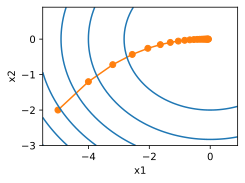

In [9]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## Adaptive Methods

As we could see in :numref:`subsec_gd-learningrate`, getting the learning rate $\eta$ "just right" is tricky. If we pick it too small, we make little progress. If we pick it too large, the solution oscillates and in the worst case it might even diverge. What if we could determine $\eta$ automatically or get rid of having to select a learning rate at all?
Second-order methods that look not only at the value and gradient of the objective function
but also at its *curvature* can help in this case. While these methods cannot be applied to deep learning directly due to the computational cost, they provide useful intuition into how to design advanced optimization algorithms that mimic many of the desirable properties of the algorithms outlined below.


### Newton's Method

Reviewing the Taylor expansion of some function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ there is no need to stop after the first term. In fact, we can write it as

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$
:eqlabel:`gd-hot-taylor`

To avoid cumbersome notation we define $\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$ to be the Hessian of $f$, which is a $d \times d$ matrix. For small $d$ and simple problems $\mathbf{H}$ is easy to compute. For deep neural networks, on the other hand, $\mathbf{H}$ may be prohibitively large, due to the cost of storing $\mathcal{O}(d^2)$ entries. Furthermore it may be too expensive to compute via backpropagation. For now let's ignore such considerations and look at what algorithm we would get.

After all, the minimum of $f$ satisfies $\nabla f = 0$.
Following calculus rules in :numref:`subsec_calculus-grad`,
by taking derivatives of :eqref:`gd-hot-taylor` with regard to $\boldsymbol{\epsilon}$ and ignoring higher-order terms we arrive at

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

That is, we need to invert the Hessian $\mathbf{H}$ as part of the optimization problem.

As a simple example, for $f(x) = \frac{1}{2} x^2$ we have $\nabla f(x) = x$ and $\mathbf{H} = 1$. Hence for any $x$ we obtain $\epsilon = -x$. In other words, a *single* step is sufficient to converge perfectly without the need for any adjustment! Alas, we got a bit lucky here: the Taylor expansion was exact since $f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$.

Let's see what happens in other problems.
Given a convex hyperbolic cosine function $f(x) = \cosh(cx)$ for some constant $c$, we can see that
the global minimum at $x=0$ is reached
after a few iterations.


epoch 10, x: 0.0


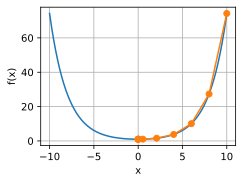

In [10]:
c = np.array(0.5)

def f(x):  # Objective function
    return np.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * np.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * np.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

Now let's consider a *nonconvex* function, such as $f(x) = x \cos(c x)$ for some constant $c$. After all, note that in Newton's method we end up dividing by the Hessian. This means that if the second derivative is *negative* we may walk into the direction of *increasing* the value of $f$.
That is a fatal flaw of the algorithm.
Let's see what happens in practice.


epoch 10, x: 26.834133


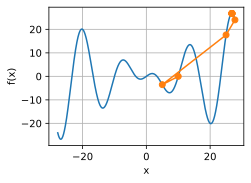

In [11]:
c = np.array(0.15 * np.pi)

def f(x):  # Objective function
    return x * np.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return np.cos(c * x) - c * x * np.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

show_trace(newton(), f)

This went spectacularly wrong. How can we fix it? One way would be to "fix" the Hessian by taking its absolute value instead. Another strategy is to bring back the learning rate. This seems to defeat the purpose, but not quite. Having second-order information allows us to be cautious whenever the curvature is large and to take longer steps whenever the objective function is flatter.
Let's see how this works with a slightly smaller learning rate, say $\eta = 0.5$. As we can see, we have quite an efficient algorithm.


epoch 10, x: 7.26986


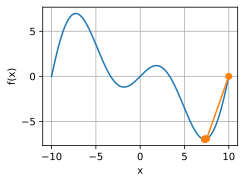

In [12]:
show_trace(newton(0.5), f)

### Convergence Analysis

We only analyze the convergence rate of Newton's method for some convex and three times differentiable objective function $f$, where the second derivative is nonzero, i.e., $f'' > 0$. The multivariate proof is a straightforward extension of the one-dimensional argument below and omitted since it does not help us much in terms of intuition.

Denote by $x^{(k)}$ the value of $x$ at the $k^\mathrm{th}$ iteration and let $e^{(k)} \stackrel{\mathrm{def}}{=} x^{(k)} - x^*$ be the distance from optimality at the $k^\mathrm{th}$ iteration. By Taylor  expansion we have that the condition $f'(x^*) = 0$ can be written as

$$0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}),$$

which holds for some $\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$. Dividing the above expansion by $f''(x^{(k)})$ yields

$$e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.$$

Recall that we have the update $x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$.
Plugging in this update equation and taking the absolute value of both sides, we have

$$\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.$$

Consequently, whenever we are in a region of bounded $\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$, we have a quadratically decreasing error

$$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.$$


As an aside, optimization researchers call this *linear* convergence, whereas a condition such as $\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$ would be called a *constant* rate of convergence.
Note that this analysis comes with a number of caveats.
First, we do not really have much of a guarantee when we will reach the region of rapid convergence. Instead, we only know that once we reach it, convergence will be very quick. Second, this analysis requires that $f$ is well-behaved up to higher-order derivatives. It comes down to ensuring that $f$ does not have any "surprising" properties in terms of how it might change its values.



### Preconditioning

Quite unsurprisingly computing and storing the full Hessian is very expensive. It is thus desirable to find alternatives. One way to improve matters is *preconditioning*. It avoids computing the Hessian in its entirety but only computes the *diagonal* entries. This leads to update algorithms of the form

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).$$


While this is not quite as good as the full Newton's method, it is still much better than not using it.
To see why this might be a good idea consider a situation where one variable denotes height in millimeters and the other one denotes height in kilometers. Assuming that for both the natural scale is in meters, we have a terrible mismatch in parameterizations. Fortunately, using preconditioning removes this. Effectively preconditioning with gradient descent amounts to selecting a different learning rate for each variable (coordinate of vector $\mathbf{x}$).
As we will see later, preconditioning drives some of the innovation in stochastic gradient descent optimization algorithms.


### Gradient Descent with Line Search

One of the key problems in gradient descent is that we might overshoot the goal or make insufficient progress. A simple fix for the problem is to use line search in conjunction with gradient descent. That is, we use the direction given by $\nabla f(\mathbf{x})$ and then perform binary search as to which learning rate $\eta$ minimizes $f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$.

This algorithm converges rapidly (for an analysis and proof see e.g., :citet:`Boyd.Vandenberghe.2004`). However, for the purpose of deep learning this is not quite so feasible, since each step of the line search would require us to evaluate the objective function on the entire dataset. This is way too costly to accomplish.

## Summary

* Learning rates matter. Too large and we diverge, too small and we do not make progress.
* Gradient descent can get stuck in local minima.
* In high dimensions adjusting the learning rate is complicated.
* Preconditioning can help with scale adjustment.
* Newton's method is a lot faster once it has started working properly in convex problems.
* Beware of using Newton's method without any adjustments for nonconvex problems.

## Exercises

1. Experiment with different learning rates and objective functions for gradient descent.
1. Implement line search to minimize a convex function in the interval $[a, b]$.
    1. Do you need derivatives for binary search, i.e., to decide whether to pick $[a, (a+b)/2]$ or $[(a+b)/2, b]$.
    1. How rapid is the rate of convergence for the algorithm?
    1. Implement the algorithm and apply it to minimizing $\log (\exp(x) + \exp(-2x -3))$.
1. Design an objective function defined on $\mathbb{R}^2$ where gradient descent is exceedingly slow. Hint: scale different coordinates differently.
1. Implement the lightweight version of Newton's method using preconditioning:
    1. Use diagonal Hessian as preconditioner.
    1. Use the absolute values of that rather than the actual (possibly signed) values.
    1. Apply this to the problem above.
1. Apply the algorithm above to a number of objective functions (convex or not). What happens if you rotate coordinates by $45$ degrees?

[Discussions](https://discuss.d2l.ai/t/351)
